<a href="https://colab.research.google.com/github/bassel-94/BERT/blob/main/code/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment analysis with BERT

## Part I : Import libraries and data

In [ ]:
%pip install transformers sentencepiece

In [ ]:
%run /content/drive/MyDrive/functions_postprocessing.ipynb

In [ ]:
# to silence any warnings
import warnings
warnings.filterwarnings("ignore")

# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, f1_score

# import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline

# load pretrained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("tblard/tf-allocine")
model = TFAutoModelForSequenceClassification.from_pretrained("tblard/tf-allocine")
nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

In [ ]:
df = pd.read_csv("./raw_data.csv", index_col = 0).dropna()
print(df.shape)
df.head()

(13827, 5)


,name,date,notes,company,comments
0,Kassandre,jeudi 25 mars 2021 à 07:23,1.0,groupama,J'ai résilié mon contrat de mutuelle en DÉCEMB...
1,MM,mardi 23 mars 2021 à 13:21,2.5,groupama,"Deux petits sinistres indemnisés et,... un cou..."
2,LFA156,mardi 23 mars 2021 à 12:24,2.0,groupama,"Bonjour, Mon motif d'insatisfaction concerne l..."
3,Claude59,lundi 22 mars 2021 à 22:57,1.0,groupama,Avis à tous mes prospects GROUPAMA: Fuyez pauv...
4,Hannah,lundi 22 mars 2021 à 14:09,1.0,groupama,Suite à un 'envoi' que je n ai jamais reçu mon...


In [ ]:
# print the concurrence
print("companies are", " ".join(df.company.unique()))
df = df.sort_values('company').reset_index(drop=True)

companies are groupama maif maaf pacifica credit-mutuel axa


## Part II : Build sentiment column and explore count

To do sentiment analysis, we will first consider the extemes (pos and neg sentiment). To do so we

* load the raw data of all insurance companies (13.8k of data)
* divid into two extemes based on the column "note" (1 & 1.5 for negatives and 4.5 & 5 for positives)
* make predictions using the finetuned camemBERT of allo ciné
* save the dataframe containing the predictions 
* analyze the error

In [ ]:
# transform notes to string
df[["notes"]] = df[["notes"]].astype(str)

# filter positif comments using 5 and 4.5 ratings only and get comments & notes column
df_pos = df.loc[(df.notes == "5.0") | (df.notes == "4.5" ), :]

# create a column for labels
df_pos["sentiment"] = ["POSITIVE"]*len(df_pos)

# filter negative comments using 1 and 1.5 ratings only and get comments & notes column
df_neg = df.loc[(df.notes == "1.0") | (df.notes == "1.5" ), :]

# create a column for labels
df_neg["sentiment"] = ["NEGATIVE"]*len(df_neg)

# concatenate row wise the two dataframes and print stats
df_sent = pd.concat([df_pos, df_neg], axis = 0)
print("we have {} positive reviews and {} negative reviews" .format(df_pos.shape[0], df_neg.shape[0]))

we have 1358 positive reviews and 5059 negative reviews


<Figure size 864x576 with 0 Axes>

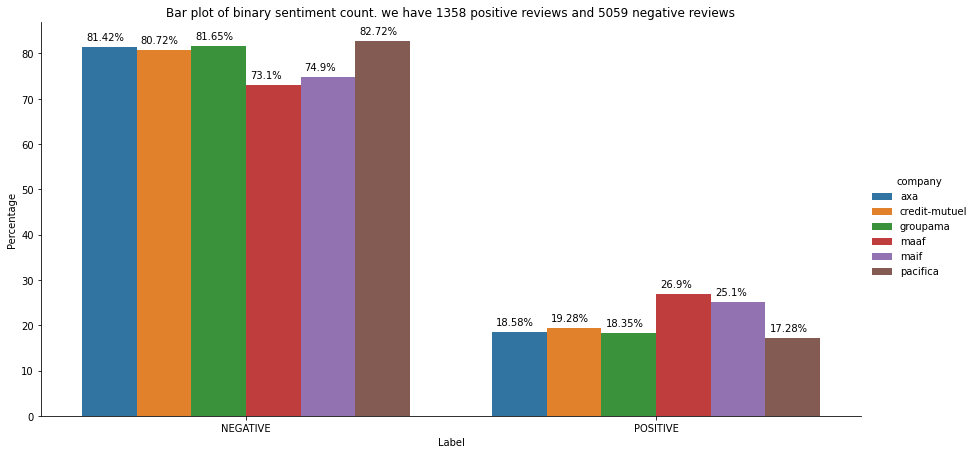

In [ ]:
# plot results of positive and negative reviews
sentiment_counts = (df_sent.groupby(['company'])['sentiment']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('company'))

plt.figure(figsize=(12, 8));
g = sns.catplot(x="sentiment", y="percentage", hue="company", data=sentiment_counts, kind = 'bar',height=6, aspect=2);

# add titles
plt.xlabel("Label");
plt.ylabel("Percentage");
plt.title("Bar plot of binary sentiment count. we have {} positive reviews and {} negative reviews" .format(df_pos.shape[0], df_neg.shape[0]));

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x()+0.01
    txt_y = p.get_height()+1.5
    g.ax.text(txt_x,txt_y,txt);

## Part III : Get sentiment predictions and probabilities

In [ ]:
#df_subset = df_sent.loc[:, ["company", "comments", "notes", "sentiment"]].sample(n=10, random_state=10)
#df_subset

In [ ]:
df_sent = get_sentiment_prediction(df = df_sent, model = model, tokenizer=tokenizer)

In [ ]:
df_sent.head()

,name,date,notes,company,comments,sentiment,predicted_sentiment,predicted_probability
33,patrice.31320,mardi 22 mars 2016 à 20:35,5.0,axa,Prix et garanties imbattables comparés aux aut...,POSITIVE,POSITIVE,0.915408
80,steph,vendredi 03 juin 2016 à 04:04,5.0,axa,SUPER ASSURANCE J AI 3 VEHICULES un 4X4 une 20...,POSITIVE,POSITIVE,0.969007
140,ludo,mardi 14 juillet 2015 à 01:21,5.0,axa,"Excellent ! Les prix, l'accueil, les garanties...",POSITIVE,POSITIVE,0.998310
149,papimoto,jeudi 20 août 2015 à 17:23,5.0,axa,Assurance très sérieuse qui enrobe passager et...,POSITIVE,NEGATIVE,0.543781
159,bb,vendredi 05 février 2016 à 23:25,5.0,axa,bonjour juste pour dire que le contrat AMV de ...,POSITIVE,NEGATIVE,0.700319
